![](https://images.aicrowd.com/raw_images/challenges/banner_file/900/829854c277eda136d9c9.jpg)


# Segmentation Model

  - Using [segmentation_model.pytorch](https://github.com/qubvel/segmentation_models.pytorch) and **DeepLabV3** for **multi class** semantic segmentation

# 0. Installing aircrowd-cli and downloading Dataset


In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c scene-segmentation -o data

test.zip:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

# 1. Downloading & Importing Libraries

Here we are going to use segmentation_models.pytorch which is a really popular library providing a tons of different segmentation models for pytorch including basic unets to DeepLabV3

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
!pip install natsort

In [ ]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
from natsort import natsorted
from tqdm.notebook import tqdm
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# 2. Create Train & Validation Dataset

In [ ]:
IMAGE_PATH = './data/train/image/'
MASK_PATH = './data/train/segmentation/'

In [ ]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  4000


In [ ]:
#split data
X_train, X_val = train_test_split(df['id'].values, test_size=0.20, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  3200
Val Size     :  800


In [ ]:
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/train/image
!mkdir dataset/train/segmentation

!mkdir dataset/val
!mkdir dataset/val/image
!mkdir dataset/val/segmentation

In [ ]:
import shutil
 
source = "./data/train"
destination = "dataset/train"

for i in os.listdir(os.path.join(source,"image")):
    if i.split('.')[0] in X_train:
        shutil.copy(os.path.join(source,"image",i), os.path.join(destination,"image",i))

for i in os.listdir(os.path.join(source,"segmentation")):
    if i.split('.')[0] in X_train:
        shutil.copy(os.path.join(source,"segmentation",i), os.path.join(destination,"segmentation",i))
        
source = "./data/train"
destination = "dataset/val"

for i in os.listdir(os.path.join(source,"image")):
    if i.split('.')[0] in X_val:
        shutil.copy(os.path.join(source,"image",i), os.path.join(destination,"image",i))

for i in os.listdir(os.path.join(source,"segmentation")):
    if i.split('.')[0] in X_val:
        shutil.copy(os.path.join(source,"segmentation",i), os.path.join(destination,"segmentation",i))

### Visualize a data point

Image Size (512, 512, 3)
Mask Size (512, 512)


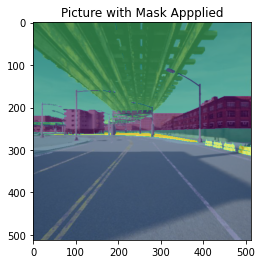

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

#3. Creating the Dataloader

In this section, we will be creating the dataloader that our model will use for the loading batches of corrosponding features and labels for training & testing

In [ ]:
class SemanticSegmentationDataset(Dataset):
    
    def __init__(self, img_directory=None, label_directory=None, train=True):
        self.img_directory = img_directory
        self.label_directory = label_directory            

        if img_directory != None:
            if train:
                self.img_list = natsorted(os.listdir(img_directory))
            else:
                self.img_list = natsorted(os.listdir(img_directory))

        if train:
            self.label_list = natsorted(os.listdir(label_directory))

        self.train = train

        self.labels = list(range(0, 23))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        # Reading the image
        img = Image.open(os.path.join(self.img_directory, self.img_list[idx]))
        img = img.convert("L")

        if self.train == True:
          
            # Reading the mak image
            mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))

            # mask.show()
            img = np.array(img, dtype=np.float32)
            mask = np.array(mask, dtype=np.float32)

            # Change image channel ordering
            img = img[np.newaxis, :, :]


            # Normalizing images
            img = torch.from_numpy(img)
            img = img.float()/255

            binary_mask = np.array([(mask == v) for v in list(self.labels)])
            binary_mask = np.stack(binary_mask, axis=-1).astype('float')

            mask_preprocessed = binary_mask.transpose(2, 0, 1)
            mask_preprocessed = torch.from_numpy(mask_preprocessed)

            return img, mask_preprocessed
        
        # If reading test dataset, only return image 
        else:
          
            img = np.array(img, dtype=np.float32)
            img = img[np.newaxis, :, :]
            # img = np.moveaxis(img, -1, 0)

            # Normalizing images
            img = torch.from_numpy(img)
            img = img.float()/255
          
            return img

In [ ]:
data_dir = "dataset"

# Creating the training dataset
train_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir,"train/image"), 
                                            label_directory=os.path.join(data_dir,"train/segmentation"))
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=True)

# Creating the validation dataset
val_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir,"val/image"), 
                                            label_directory=os.path.join(data_dir,"val/segmentation"))
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=True)


In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 23, 512, 512]))

## Visualizing distinct mask

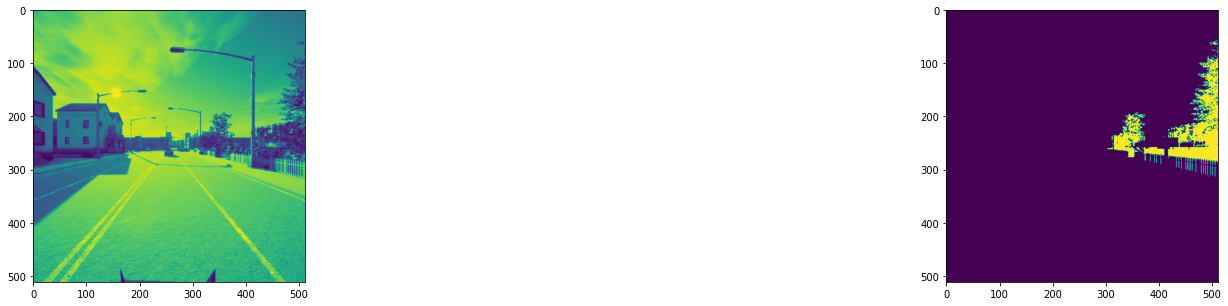

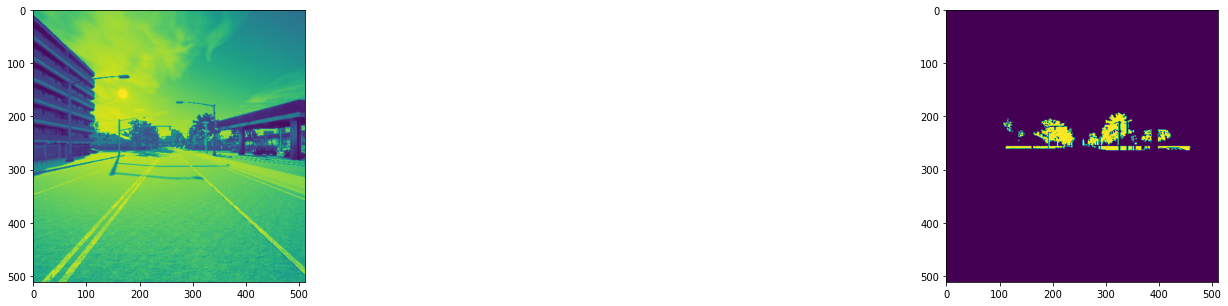

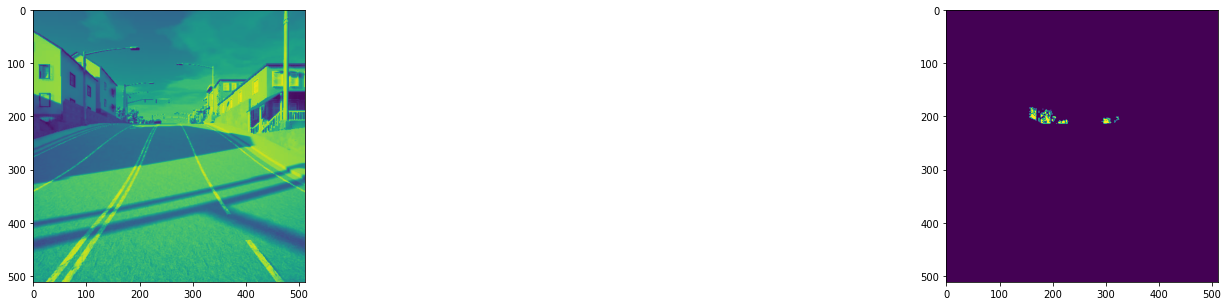

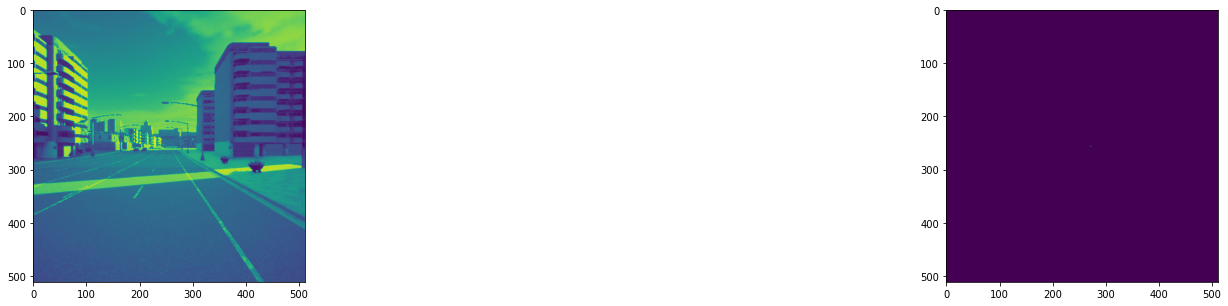

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

    # Change the channel ordering
    image = np.moveaxis(image.numpy()*255, 0, -1)

    # Showing the image
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image[:, :, 0])
    plt.subplot(1,2,2)
    plt.imshow(segmentation[9]*255)
    plt.show()

In [ ]:
segmentation.shape

torch.Size([23, 512, 512])

#4. Creating the Model

Here we will get setting up the model architecture, optimizer and loss.



In [ ]:
ENCODER = 'timm-efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = "softmax2d" 
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(train_dataset.labels),
    in_channels=1,
    activation=ACTIVATION,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

## Hyperparameters & Metrics

In [ ]:
# using DiceLoss
loss = smp.utils.losses.DiceLoss()

# using multiple metrics to train the model
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]

# Using SGD optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

## Training the Model

**Saved Model and be loaded here and and trained**

In [ ]:
# Setting up training epoch to train the model
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
    )

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
    )

### **Model is saved based on the validation F1 Score** 

In [ ]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = val_epoch.run(val_loader) 
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, 'best_model.pth')
        print('Model saved!')
        
    if i == 20:
        # lr is reduced 
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

#5. Generating Predictions

In [ ]:
# Creating the testing dataset
data_dir_ = "./data"

test_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir_,"test/image"), train=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2, shuffle=False, drop_last=False)

### Load the best model

In [ ]:
# load the best model
model = torch.load("./best_model.pth")

In [ ]:
# Generating Model Predictions
!rm -rf segmentation
!mkdir segmentation

for n, batch in enumerate(tqdm(test_loader)):

    # Getting the predictions
    predictions = model.predict(batch.to(DEVICE)).cpu() 
  
    # Converting the predictions to right format
    prediction_mask = (predictions.squeeze().cpu().numpy())   
    prediction_mask = np.transpose(prediction_mask, (1, 2, 0))

    # Getting individual channel and combining them into single image
    prediction_mask_gray = np.zeros((prediction_mask.shape[0],prediction_mask.shape[1]))
    for ii in range(prediction_mask.shape[2]):
        prediction_mask_gray = prediction_mask_gray + ii*prediction_mask[:,:,ii].round()


    # Saving the image
    prediction_mask_gray = Image.fromarray(prediction_mask_gray.astype(np.uint8))
    prediction_mask_gray.save(os.path.join("segmentation", f"{n}.png"))

  0%|          | 0/1000 [00:00<?, ?it/s]

## Analyze the Predictions

In [ ]:
# Creating the testing dataset
data_dir_ = "./data"

test_dataset = SemanticSegmentationDataset(img_directory=os.path.join(data_dir_,"test/image"),
                                           label_directory=os.path.join("segmentation"))
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=False)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(test_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 23, 512, 512]))

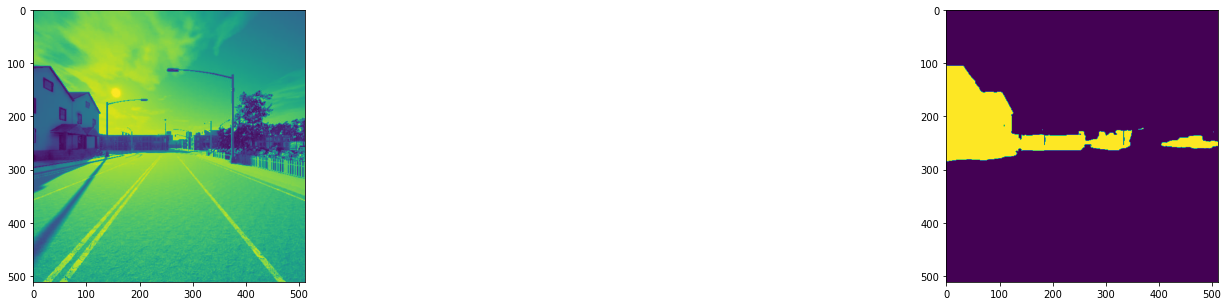

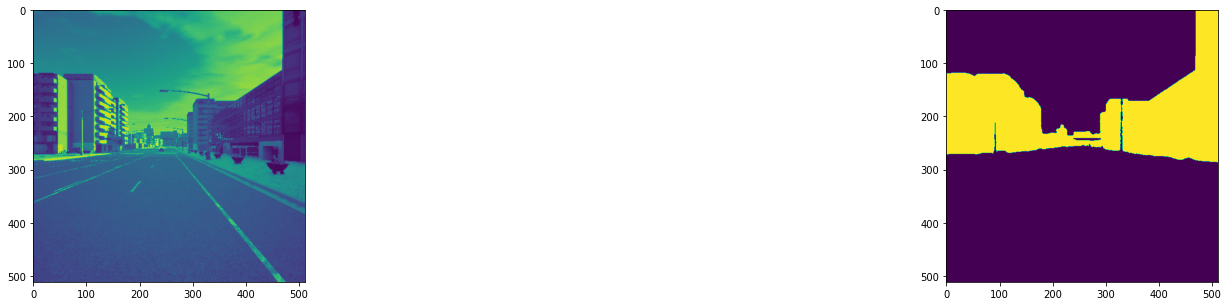

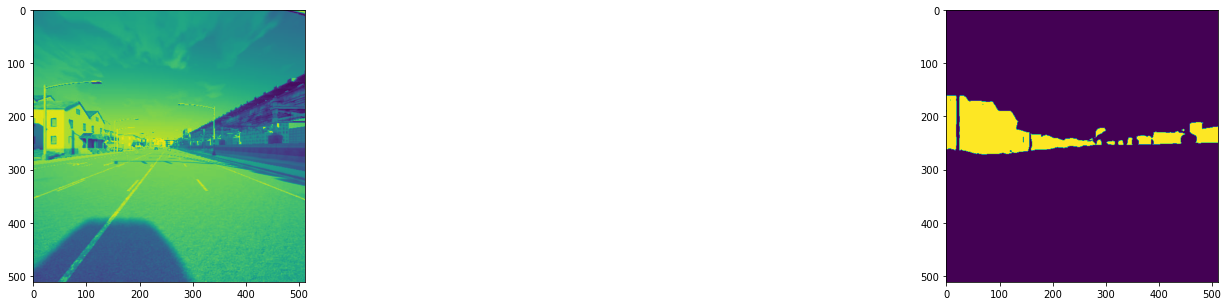

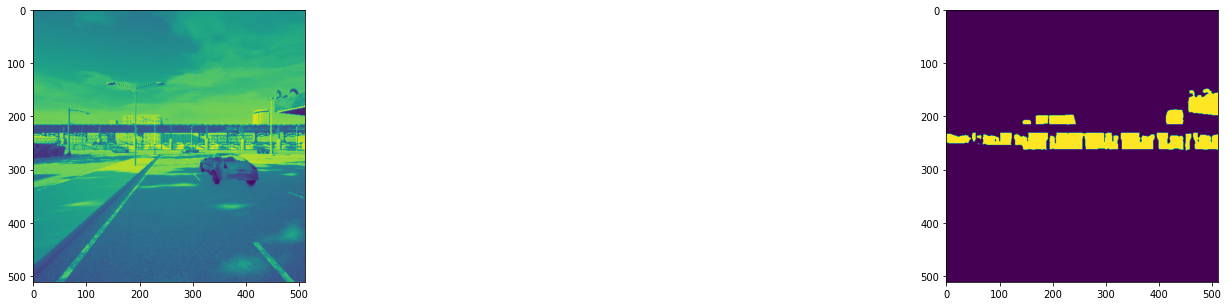

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

    # Change the channel ordering
    image = np.moveaxis(image.numpy()*255, 0, -1)

    # Showing the image
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image[:, :, 0])
    plt.subplot(1,2,2)
    plt.imshow(segmentation[1]*255)
    plt.show()

Image Size (512, 512, 3)
Mask Size (512, 512)


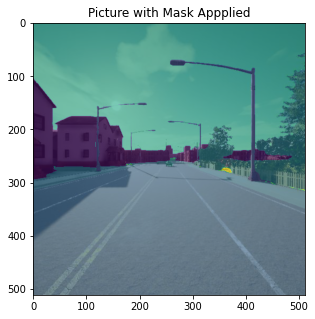

In [ ]:
id = 432
img = Image.open("data/test/image/"+str(id)+".jpg")
mask = Image.open("segmentation/" + str(id) + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Submitting our Predictions
**Note : Please save the notebook before submitting it (Ctrl + S)**

In [ ]:
%aicrowd notebook submit -c scene-segmentation -a segmentation --no-verify